# Table of Contents

- [Data Collection](#data-collection)
  - [Data: 311](#data-311)
  - [Data: Shootings](#data-shootings)
- [Data Analysis](#data-analysis)
  - [Create Panel Data](#create-panel-data)
  - [See the Pooled Data](#see-the-pooled-data)
  - [Regression](#regression)
    - [Pooled Model](#pooled-model)
    - [Linear Panel](#linear-panel)
    - [Log Panel](#log-panel)
- [Conclusion](#conclusion)
- [Extra Extra Experimenting with Census Data](#extra-extra-experimenting-with-census-data)
  - [Census Data American Community Survey](#census-data-american-community-survey)
  - [Panel model with Census data](#panel-model-with-census-data)


# Data Collection

## Data: 311

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

In [ ]:
# API Setup
load_dotenv()
NYC_OPENDATA_TOKEN = os.getenv('NYC_OPENDATA_TOKEN')

# Check that they were successfully accessed

if NYC_OPENDATA_TOKEN:
  print('NYC_OPENDATA token retrieved successfully.')
else:
  print('Could not find NYC_OPENDATA :(')

NYC_OPENDATA tocken retrieved successfully.


In [3]:
import requests
import time
from tqdm import tqdm

In [4]:
start_year = 2010
end_year = 2023
# The data is available from 2010 to 2022. This is because our Census data is up to 2022.

In [ ]:
# Setup

# NYC Open Data 311 API setup
APP_TOKEN = NYC_OPENDATA_TOKEN
BASE_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"
headers = {"X-App-Token": APP_TOKEN}

# Years and complaint types to query
years = list(range(start_year, end_year))

# We're focusing on specific complaint types to reduce the likelihood of reverse-causality with violence
target_complaints = [
    "Dirty Condition", "Missed Collection", "Rodent", "Illegal Dumping",
    "Dead Animal", "Noise - Residential", "Noise - Vehicle", "Noise - Helicopter",
    "Street Condition", "Sidewalk Condition", "Street Sign - Missing",
    "Broken Parking Meter", "Curb Condition", "Snow or Ice", "Mold",
    "Air Quality", "Water Maintenance", "Sewer Maintenance", "Trapping Pigeon",
    "Unleashed Dog", "Overgrown Tree/Branches", "Dead/Dying Tree"
]

# Map borough names to standard 2-letter codes
borough_codes = {
    "MANHATTAN": "MN",
    "BRONX": "BX",
    "BROOKLYN": "BK",
    "QUEENS": "QN",
    "STATEN ISLAND": "SI"
}

In [6]:
all_counts = []

for year in years:
    print(f"\nGetting 311 complaint counts for {year}...")

    # Build WHERE clause
    date_filter = (
        f"created_date >= '{year}-01-01T00:00:00' AND "
        f"created_date < '{year + 1}-01-01T00:00:00'"
    )
    complaint_filter = " OR ".join([
        f"upper(complaint_type) LIKE '%{c.upper()}%'" for c in target_complaints
    ])
    where_clause = f"{date_filter} AND ({complaint_filter}) AND community_board IS NOT NULL"

    # Request from API
    params = {
        "$select": "community_board, count(*) as count",
        "$where": where_clause,
        "$group": "community_board"
    }

    response = requests.get(BASE_URL, headers=headers, params=params)
    data = pd.DataFrame(response.json())

    if data.empty:
        print(f"No data returned for {year}")
        continue

    # Convert and extract geo_id
    data["count"] = data["count"].astype(int)
    parts = data["community_board"].str.upper().str.extract(r"^(\d{2})\s+([A-Z ]+)$")
    data["geo_id"] = parts[1].str.strip().map(borough_codes) + parts[0]

    # Preview rows with bad geo_id
    bad_geo_rows = data[data["geo_id"].isna()]
    n_bad = len(bad_geo_rows)
  
    # Drop invalid rows
    data = data.dropna(subset=["geo_id"])

    # Group to ensure no duplicates and rename column
    data = (
        data.groupby("geo_id", as_index=True)["count"]
        .sum()
        .rename(year) # .rename(f"311_{year}")
        .to_frame()
    )

    all_counts.append(data)

    print(f"Year {year}... {len(data)} districts ({n_bad} bad rows dropped)")


Getting 311 complaint counts for 2010...
Year 2010... 70 districts (6 bad rows dropped)

Getting 311 complaint counts for 2011...
Year 2011... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2012...
Year 2012... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2013...
Year 2013... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2014...
Year 2014... 70 districts (6 bad rows dropped)

Getting 311 complaint counts for 2015...
Year 2015... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2016...
Year 2016... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2017...
Year 2017... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2018...
Year 2018... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2019...
Year 2019... 71 districts (6 bad rows dropped)

Getting 311 complaint counts for 2020...
Year 2020... 71 districts (6 bad rows dropped)

Getting 311 complain

In [7]:
# Combine into one DataFrame
combined_311_df = (
    pd.concat(all_counts, axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()  # 👈 brings geo_id back as a regular column
)

In [8]:
combined_311_df

,geo_id,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,BK01,6587,6751,6939,7673,12670,12941,13277,13229,14684,17081,19009,19103,19943
1,BK02,4827,5278,4485,5119,7089,8021,12252,8866,9524,10479,10331,11676,13127
2,BK03,6828,7078,7692,8389,10845,13086,13009,13107,14109,15360,16882,18882,18236
3,BK04,4261,4476,5023,5876,8074,9238,9703,10589,10005,13702,14519,14272,13239
4,BK05,6867,6804,6710,6889,8994,11313,10154,11105,11130,11732,15474,17874,15597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,SI01,8153,8345,8299,8546,11800,15410,13828,13939,16607,16985,16991,19124,15521
67,SI02,5363,5806,5245,5708,7646,10275,9439,9693,10185,10735,9461,12978,12492
68,SI03,6160,6376,6252,7148,8595,13161,10711,12072,12340,14360,13820,18234,16322
69,SI95,10,7,5,13,19,10,12,14,37,48,28,18,108


## Data: Shootings

In [9]:
# Constants
APP_TOKEN = NYC_OPENDATA_TOKEN
BASE_URL = "https://data.cityofnewyork.us/resource/833y-fsy8.json"
LIMIT = 1000
TOTAL_ROWS = 29744

# Set headers
headers = {
    "X-App-Token": APP_TOKEN
}

# Initialize
raw_crime_data = []

# Calculate number of batches
num_batches = (TOTAL_ROWS // LIMIT) + 1

# Loop with progress bar
for offset in tqdm(range(0, TOTAL_ROWS, LIMIT), desc="Downloading NYPD Data"):
    params = {
        "$limit": LIMIT,
        "$offset": offset
    }
    response = requests.get(BASE_URL, params=params, headers=headers)
    crime_data = response.json()

    if not crime_data:
        break

    raw_crime_data.extend(crime_data)
    time.sleep(0.1)  # Be polite to the API

In [10]:
all_crime_data = pd.DataFrame(raw_crime_data)

NYPD data is by precinct, but we want to work with community districts.
Unfortunately, some precincts do not neatly overlap with community districts. So we're instead going to use the latitude and longitude of the complaints, and map those to the community districts.

In [11]:
# Drop any rows that have zero or NaN values in 'latitude' and 'longitude'
all_crime_data.loc[:, "latitude"] = pd.to_numeric(all_crime_data["latitude"])
all_crime_data.loc[:, "longitude"] = pd.to_numeric(all_crime_data["longitude"])

all_crime_data = all_crime_data[
    all_crime_data["latitude"].notna() &
    all_crime_data["longitude"].notna() &
    (all_crime_data["latitude"] != 0.0) &
    (all_crime_data["longitude"] != 0.0)
]
all_crime_data

,incident_key,occur_date,occur_time,boro,loc_of_occur_desc,precinct,jurisdiction_code,loc_classfctn_desc,location_desc,statistical_murder_flag,...,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer
0,298699604,2024-12-31T00:00:00.000,19:16:00,BROOKLYN,OUTSIDE,69,0,STREET,(null),False,...,"1,015,120","173,870",40.643866,-73.888761,"{'type': 'Point', 'coordinates': [-73.888761, ...",2,8,42,13827,5
1,298699604,2024-12-31T00:00:00.000,19:16:00,BROOKLYN,OUTSIDE,69,0,STREET,(null),False,...,"1,015,120","173,870",40.643866,-73.888761,"{'type': 'Point', 'coordinates': [-73.888761, ...",2,8,42,13827,5
2,298672095,2024-12-30T00:00:00.000,20:32:00,BRONX,INSIDE,41,0,DWELLING,MULTI DWELL - APT BUILD,True,...,"1,012,201","240,878",40.827795,-73.899003,"{'type': 'Point', 'coordinates': [-73.899003, ...",5,43,25,10937,34
3,298672096,2024-12-30T00:00:00.000,16:45:00,BRONX,OUTSIDE,47,0,STREET,(null),False,...,"1,021,316","259,277",40.878261,-73.865964,"{'type': 'Point', 'coordinates': [-73.865964, ...",5,2,30,11605,29
4,298672096,2024-12-30T00:00:00.000,16:45:00,BRONX,OUTSIDE,47,0,STREET,(null),False,...,"1,021,316","259,277",40.878261,-73.865964,"{'type': 'Point', 'coordinates': [-73.865964, ...",5,2,30,11605,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29739,9953250,2006-01-01T00:00:00.000,02:34:00,QUEENS,NaN,114,0,NaN,BAR/NIGHT CLUB,True,...,1002576.750000000000000,221583.453125000000000,40.774861,-73.933833,"{'type': 'Point', 'coordinates': [-73.93383258...",3,4,72,16859,39
29740,9953245,2006-01-01T00:00:00.000,02:00:00,BRONX,NaN,48,0,NaN,NONE,False,...,1013404.562500000000000,251800.750000000000000,40.85777,-73.894607,"{'type': 'Point', 'coordinates': [-73.89460745...",5,22,29,10936,6
29741,139716503,2006-01-01T00:00:00.000,12:30:00,BROOKLYN,NaN,77,0,NaN,PVT HOUSE,True,...,996441.562500000000000,184160.359375000000000,40.672154,-73.956052,"{'type': 'Point', 'coordinates': [-73.95605150...",2,48,49,17618,16
29742,9953246,2006-01-01T00:00:00.000,05:51:00,BRONX,NaN,44,0,NaN,NONE,False,...,1007418.000000000000000,243859.218750000000000,40.83599,-73.916276,"{'type': 'Point', 'coordinates': [-73.91627635...",5,42,27,10934,50


-----------------

In [12]:
from shapely.geometry import Point
import geopandas as gpd

In [13]:
# 1. Load the community districts GeoJSON
cd_gdf = gpd.read_file("CD.geo.json")

# 2. Extract geo_id from GEONAME and format (e.g., CD01, CD13)
cd_gdf["geo_id"] = (
    cd_gdf["BOROUGH"].str.upper().map(borough_codes) +
    cd_gdf["GEONAME"].str.extract(r"\(CD(\d{1,2})\)")[0].str.zfill(2)
)

# 3. Create geometry column for crime data
geometry = [Point(xy) for xy in zip(all_crime_data["longitude"], all_crime_data["latitude"])]
crime_gdf = gpd.GeoDataFrame(all_crime_data, geometry=geometry, crs="EPSG:4326")

# 4. Ensure same CRS
cd_gdf = cd_gdf.to_crs("EPSG:4326")

# 5. Spatial join
joined = gpd.sjoin(crime_gdf, cd_gdf[["geometry", "geo_id"]], how="left", predicate="within")

# 6. Assign geo_id to original DataFrame
all_crime_data["geo_id"] = joined["geo_id"]

In [14]:
# Number of rows
len(all_crime_data)

29647

In [15]:
# Some complaints (9) still have no geo_id. This is because they are on major roads or bridges, not within a community district (I checked the dropped rows separately).
# We are choosing to drop these rows, because they make up a very small percentage of the data, and because they're not located within a community district.
all_crime_data = all_crime_data.dropna(subset=["geo_id"])

In [16]:
# Number of rows
len(all_crime_data)

29638

In [17]:
# Sum of shootings per community district in 2010

# 1. Convert dates
all_crime_data["occur_date"] = pd.to_datetime(all_crime_data["occur_date"], errors="coerce")

# 2. Extract year
all_crime_data["year"] = all_crime_data["occur_date"].dt.year

# 3. Filter for after 2010 and before 2023
crime_filtered = all_crime_data[(all_crime_data["year"] >= start_year) & (all_crime_data["year"] < end_year)]

# 4. Group and pivot
shooting_counts = (
    crime_filtered
    .groupby(["geo_id", "year"])
    .size()
    .unstack(fill_value=0)
    .rename_axis(None, axis=1)        # removes 'year' from top-left
    # .add_prefix("shootings_")         # adds prefix to column names 
    .reset_index()                    # only resets geo_id
)
shooting_counts

C:\Users\Anant\AppData\Local\Temp\ipykernel_25480\326513934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_crime_data["occur_date"] = pd.to_datetime(all_crime_data["occur_date"], errors="coerce")
C:\Users\Anant\AppData\Local\Temp\ipykernel_25480\326513934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_crime_data["year"] = all_crime_data["occur_date"].dt.year


,geo_id,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,BK01,27,27,20,17,23,35,22,21,22,8,30,22,21
1,BK02,27,21,24,14,21,34,15,16,15,16,29,22,20
2,BK03,137,134,116,93,102,74,91,58,68,62,125,92,65
3,BK04,48,50,33,25,25,20,19,15,18,15,17,49,26
4,BK05,109,129,88,78,79,80,67,45,33,66,145,95,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,QN83,0,0,0,0,0,0,0,0,0,0,2,0,0
64,SI01,32,39,41,48,39,42,36,42,22,19,44,34,36
65,SI02,1,3,7,3,3,3,8,3,0,3,6,4,1
66,SI03,1,8,0,1,0,5,0,1,3,4,0,2,3


# Data Analysis

## Create Panel Data

In [18]:
panel_data = pd.DataFrame() # Initialize the empty DataFrame

In [19]:
shooting_long = shooting_counts.melt(id_vars="geo_id", var_name="year", value_name="shootings")
complaints_long = combined_311_df.melt(id_vars="geo_id", var_name="year", value_name="complaints")
panel_data = pd.merge(shooting_long, complaints_long, on=["geo_id", "year"], how="outer")

Note: All community districts have a numerical code between 0 - 20. If it is 20 or greater, this means it is a Joint Interest Area, which includes parks and other zones that can be outliers for our data, and skew our regression. As a result, these Joint Interest Areas will be dropped.

In [20]:
panel_data["district_num"] = panel_data["geo_id"].str.extract(r"(\d{2})").astype(int)
panel_data = panel_data[panel_data["district_num"] < 20].drop(columns="district_num")

In [21]:
panel_data = panel_data.set_index(["geo_id", "year"]).sort_index()

# In case we need it, I'm also adding the logs of the complaints and shootings
panel_data["log_complaints"] = np.log(panel_data["complaints"] + 1)
panel_data["log_shootings"] = np.log(panel_data["shootings"] + 1)

# Preview data
panel_data.head()

shootings  complaints  log_complaints  log_shootings
geo_id year                                                      
BK01   2010       27.0        6587        8.793005       3.332205
       2011       27.0        6751        8.817594       3.332205
       2012       20.0        6939        8.845057       3.044522
       2013       17.0        7673        8.945593       2.890372
       2014       23.0       12670        9.447071       3.178054

## See the Pooled Data

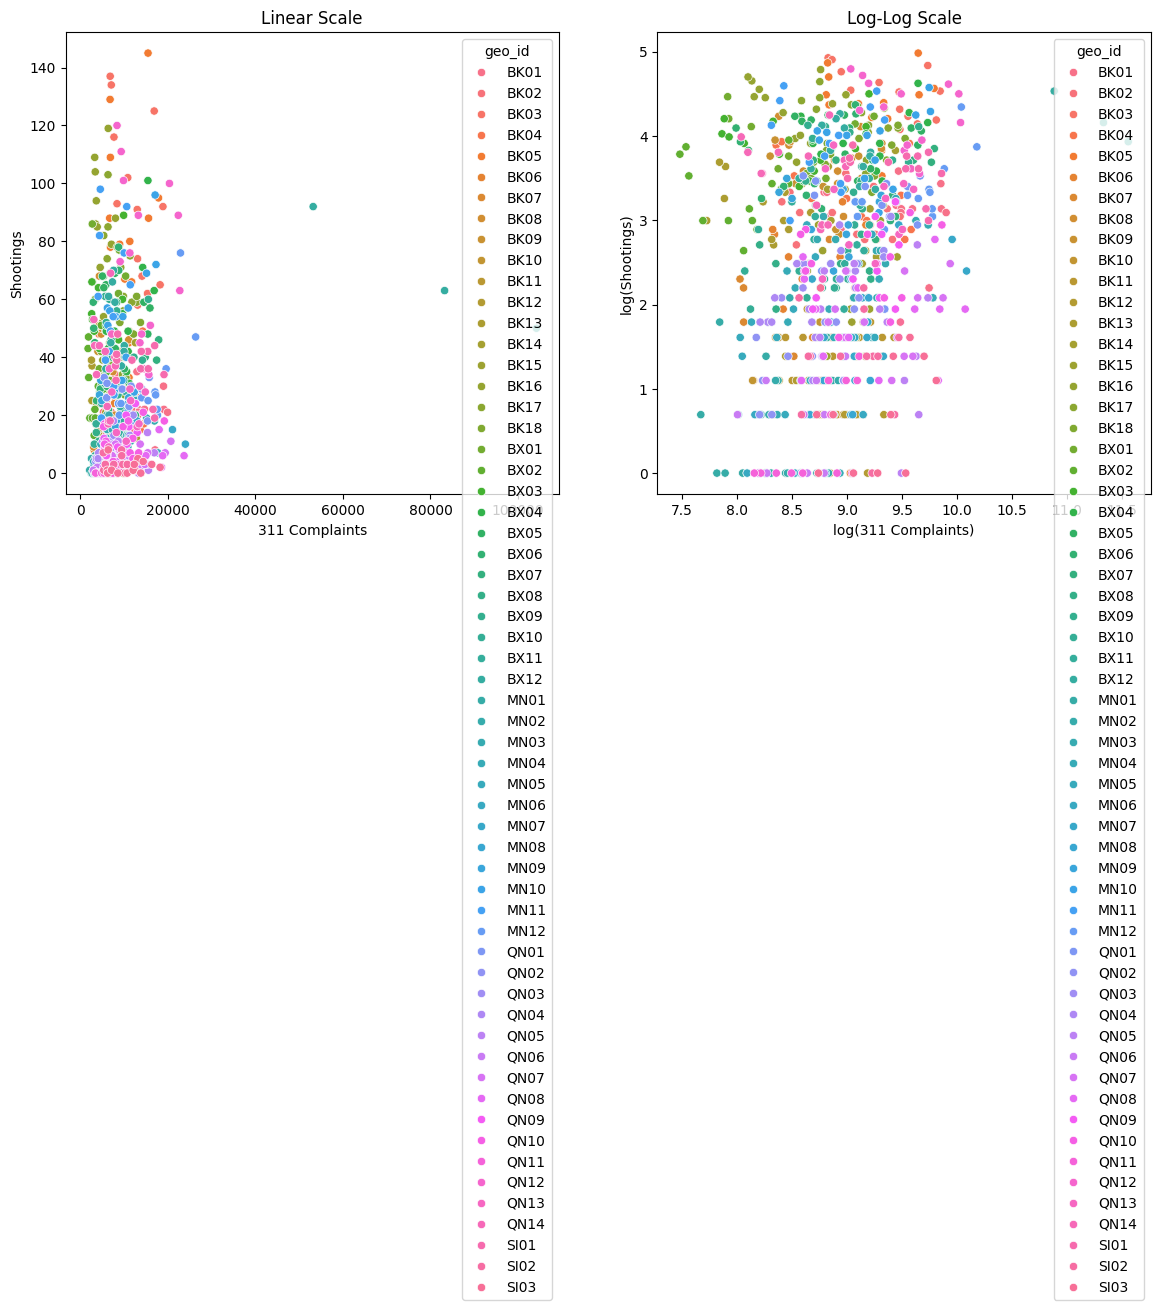

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

see_the_data = panel_data.reset_index()

# Create scatterplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear plot
sns.scatterplot(data=see_the_data, x="complaints", y="shootings", hue="geo_id", ax=axes[0])
axes[0].set_title("Linear Scale")
axes[0].set_xlabel("311 Complaints")
axes[0].set_ylabel("Shootings")

# Log-log plot
sns.scatterplot(data=see_the_data, x="log_complaints", y="log_shootings", hue="geo_id", ax=axes[1])
axes[1].set_title("Log-Log Scale")
axes[1].set_xlabel("log(311 Complaints)")
axes[1].set_ylabel("log(Shootings)")

plt.show()


Text(41.735163194444425, 0.5, 'Shootings')

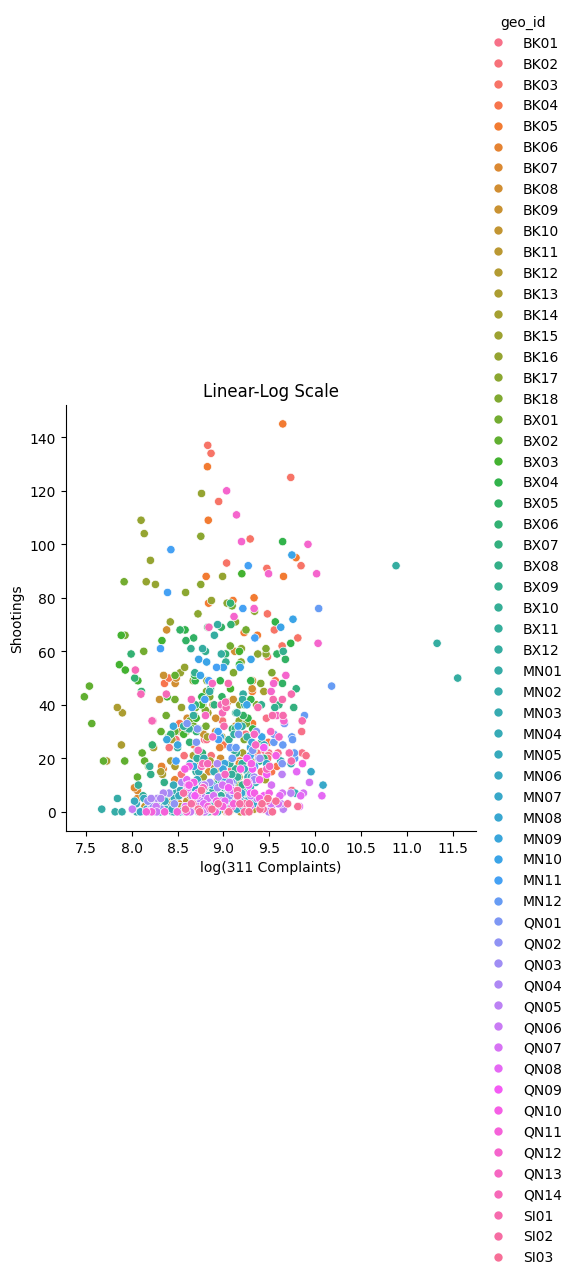

In [23]:
# We ultimately used a linear-log plot, so let's see how that looks
sns.relplot(data=see_the_data, x="log_complaints", y="shootings", kind="scatter", hue="geo_id")
plt.title("Linear-Log Scale")
plt.xlabel("log(311 Complaints)")
plt.ylabel("Shootings")

## Regression

In [24]:
import linearmodels as lm

### Pooled Model

In [25]:
pooled_model = lm.PooledOLS.from_formula('shootings ~ log_complaints + 1', data = panel_data).fit(cov_type='clustered', cluster_entity=True)
# After playing around with various linear/log combinations, the lin-log model seemed to have the clearest interpretation.


print(pooled_model.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:              shootings   R-squared:                        0.0208
Estimator:                  PooledOLS   R-squared (Between):              0.0419
No. Observations:                 767   R-squared (Within):              -0.0632
Date:                Tue, May 13 2025   R-squared (Overall):              0.0208
Time:                        13:09:48   Log-likelihood                   -3598.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.233
Entities:                          59   P-value                           0.0001
Avg Obs:                       13.000   Distribution:                   F(1,765)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             3.1732
                            

### Linear Panel

In [26]:
panel = lm.PanelOLS.from_formula(
    "shootings ~ complaints + EntityEffects + TimeEffects", data = panel_data
    ).fit(cov_type='clustered',cluster_entity=True)

print(panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              shootings   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):              0.0390
No. Observations:                 767   R-squared (Within):               0.0026
Date:                Tue, May 13 2025   R-squared (Overall):              0.0352
Time:                        13:09:48   Log-likelihood                   -2858.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1241
Entities:                          59   P-value                           0.2894
Avg Obs:                       13.000   Distribution:                   F(1,695)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             4.2670
                            

### Log Panel

In [27]:
panel = lm.PanelOLS.from_formula(
    "shootings ~ log_complaints + EntityEffects + TimeEffects", data = panel_data
    ).fit(cov_type='clustered',cluster_entity=True)

print(panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              shootings   R-squared:                        0.0051
Estimator:                   PanelOLS   R-squared (Between):              0.2135
No. Observations:                 767   R-squared (Within):              -0.0295
Date:                Tue, May 13 2025   R-squared (Overall):              0.1879
Time:                        13:09:48   Log-likelihood                   -2857.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.5609
Entities:                          59   P-value                           0.0596
Avg Obs:                       13.000   Distribution:                   F(1,695)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             6.4073
                            

# Conclusion

**Panel Model Equation**

$$
\text{shootings}_{it} = \beta_1 \cdot \log(\text{complaints}_{it} + 1) + \alpha_i + \delta_t + \varepsilon_{it}\
$$

- $i$ = community districts
- $t$ = years
- $\alpha_i$ are entity (community district) fixed effects
- $\delta_t$ are time (year) fixed effects
- The log is applied as $\log(x + 1)$ to handle zero values

**Interpretation**

- At a 5% confidence level, we conclude that for every 1% increase in select 311 complaints, there is a 0.05 increase in shootings.

 - This is taking into account effects that are:
   - Constant over time, but vary across Community Districts.
   - Constant over Community Districts, but vary across time.

- This would support the "broken windows" theory, that public order (clean streets, proper infrastructure) is correlated with public safety.

**Where the Data Came From**

- 311 data was pulled from the NYC OpenData API, and is available at [this link](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data).

- Similarly, NYPD Shooting Incident data was pulled from the NYC OpenData API, and is available at [this link](https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8/about_data).

 - This NYPD data had to be modified to specify in which Community District each shooting occurred. The geo.json file used to make this modification was retrieved from [this Github project](https://github.com/nycehs/NYC_geography/blob/master/CD.geo.json).

- Data on Community Districts is, as of now, unused. This data came from the American Community Survey, and was organized by the NYC Department of Planning. It is available at [this link](https://www.nyc.gov/content/planning/pages/resources/datasets/american-community-survey).



# Extra Extra: Experimenting with Census Data

*We ultimately chose against including data from the American Community Survey, as we lacked data for 2011-2017, and the data we did have were 5-year averages, which might have led to unnatural jumps without interpolation.*

*In the following code, we experimented with using the ACS data. We focused on the median income, the percentage of people working from home, and the percentage of people under 50% of the poverty line.*

*We used the 2006-2010 averages as the values for 2010, used the 2018-2022 averages as the values for 2020, and used regular linear interpolation for the data in-between. This is problematic because the data is almost certainly not linear: the pandemic should result in wonky data around 2020.*

*Ultimately, including these variables did not significantly impact the coefficient of $log(complaints_{it})$.*
*They did raise the $R^2$ to 0.0186, from 0.0051.*

*But because the coefficient of $log(complaints_{it})$ did not significantly change, and because none of these variables were themselves significant, we felt comfortable using the original panel model.*

![the issue with interpolation, and why we didn't use ACS data](image.png)

## Census Data (American Community Survey)

In [28]:
import openpyxl

In [29]:
econ_0610 = pd.read_excel("2010_ACS.xlsx", sheet_name="EconData") # Data from the 2006-2010 ACS 5-Year Estimates
econ_1822 = pd.read_excel("2022_ACS.xlsx", sheet_name="EconData") # Data from the 2018-2022 ACS 5-Year Estimates

In [30]:
# Step 1: Add 'year' column
econ_0610["year"] = 2010
econ_1822["year"] = 2020 

# Step 2: Select relevant variables
selected_cols = ["GeoID", "MnHHIncM", "CW_WrkdHmP", "PvU50E", "year"]
# We're getting the median income, the percentage of people working from home, and the percentage of people under 50% of the poverty line.

econ_0610 = econ_0610[selected_cols]
econ_1822 = econ_1822[selected_cols]

# Step 3: Standardize column names and rename for clarity
rename_map = {
    "GeoID": "geo_id",
    "MnHHIncM": "median_income",
    "CW_WrkdHmP": "pct_work_from_home",
    "PvU50E": "pct_under_poverty_50"
}

for df in [econ_0610, econ_1822]:
    df.rename(columns=rename_map, inplace=True)



In [31]:
# Step 4: Combine into a single DataFrame
econ_data = pd.concat([econ_0610, econ_1822], ignore_index=True)
econ_data = econ_data.sort_values(["geo_id", "year"]).reset_index(drop=True)

In [32]:
# 1. Create full index of geo_id × years
full_index = pd.MultiIndex.from_product(
    [econ_data["geo_id"].unique(), range(2010, 2023)],
    names=["geo_id", "year"]
)

# 2. Reindex to fill missing years
econ_data = econ_data.set_index(["geo_id", "year"]).reindex(full_index).sort_index()

# 3. Interpolate values for missing years
econ_data = econ_data.groupby(level=0, group_keys=False).apply(lambda g: g.interpolate()).reset_index()


In [33]:
econ_data

,geo_id,year,median_income,pct_work_from_home,pct_under_poverty_50
0,BK01,2010,1998.0,6.60,23412.0
1,BK01,2011,2322.2,8.02,23026.5
2,BK01,2012,2646.4,9.44,22641.0
3,BK01,2013,2970.6,10.86,22255.5
4,BK01,2014,3294.8,12.28,21870.0
...,...,...,...,...,...
918,SI95,2018,38763.2,1.40,0.0
919,SI95,2019,41804.1,1.40,0.0
920,SI95,2020,44845.0,1.40,0.0
921,SI95,2021,44845.0,1.40,0.0


## Panel model with Census data

In [34]:
# Get rid of community districts above 20
econ_data["district_num"] = econ_data["geo_id"].str.extract(r"(\d{2})").astype(int)
econ_data = econ_data[econ_data["district_num"] < 20].drop(columns="district_num")

In [35]:
# 1. Ensure econ_data has matching index format
econ_data = econ_data.set_index(["geo_id", "year"]).sort_index()

# 2. Join to panel_data (preserves existing index)
panel_data = panel_data.join(econ_data, how="left")

# 3. Put median income in log scale
panel_data["log_median_income"] = np.log(panel_data["median_income"] + 1)


In [36]:
ACS_model = lm.PanelOLS.from_formula(
    "shootings ~ log_complaints + log_median_income + pct_under_poverty_50 + pct_work_from_home + EntityEffects + TimeEffects",
    data=panel_data
).fit(cov_type="clustered", cluster_entity=True)

print(ACS_model.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:              shootings   R-squared:                        0.0186
Estimator:                   PanelOLS   R-squared (Between):             -16.169
No. Observations:                 767   R-squared (Within):              -0.4569
Date:                Tue, May 13 2025   R-squared (Overall):             -14.518
Time:                        13:09:50   Log-likelihood                   -2852.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.2707
Entities:                          59   P-value                           0.0114
Avg Obs:                       13.000   Distribution:                   F(4,692)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             3.3575
                            

In [37]:
from linearmodels.panel import compare

compare_models = compare(
    {"Restricted": panel, "Full": ACS_model},
    precision='std_errors'
)

In [38]:
print(compare_models)

                  Model Comparison                  
                            Restricted          Full
----------------------------------------------------
Dep. Variable                shootings     shootings
Estimator                     PanelOLS      PanelOLS
No. Observations                   767           767
Cov. Est.                    Clustered     Clustered
R-squared                       0.0051        0.0186
R-Squared (Within)             -0.0295       -0.4569
R-Squared (Between)             0.2135       -16.169
R-Squared (Overall)             0.1879       -14.518
F-statistic                     3.5609        3.2707
P-value (F-stat)                0.0596        0.0114
======================     ===========   ===========
log_complaints                  5.1011        5.0641
                              (2.0152)      (2.2422)
log_median_income                             13.138
                                            (8.0616)
pct_under_poverty_50                          